## Descriptions:
Reads isocontours from a number of timesteps and seperates the data according to the algebraic value of curvature into groups. For example using 3 groups we can have Group 0 with curvature below -0.01, Group 1 with -0.01< curvature < 0.01 and Group 2 with curvature > 0.01. Then, for each group it trains a Random Forest Regressor to predict Sd and uses the SHAP library to show the effect of each input towards the prediction of Sd for this specific RF model.

In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

from flamekit.io_fields import field_path
from flamekit.io_fronts import Case, load_fronts

### Read config and define helper functions

In [2]:
PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "case_studies/Feature_importance_SHAP_curvature_bins" / "Feature_importance_SHAP_curvature_bins.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

BASE_DIR = PROJECT_ROOT / Path(CFG["BASE_DIR"])
PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
POST = bool(CFG["POST"])

TIME_STEPS = list(CFG["TIME_STEPS"])
ISOLEVEL = float(CFG["ISOLEVEL"])
TARGET_VAR = str(CFG["TARGET_VAR"])
TARGET_LABEL = str(CFG["TARGET_LABEL"])
HIST_BINS = int(CFG["HIST_BINS"])

CLUSTER_ON_SPATIAL = bool(CFG["CLUSTER_ON_SPATIAL"])

CLUSTER_FEATURES_INCLUDE = set(CFG["CLUSTER_FEATURES_INCLUDE"])

MODEL_FEATURES_INCLUDE = set(CFG["MODEL_FEATURES_INCLUDE"])

FEATURES_EXCLUDE = set(CFG.get("FEATURES_EXCLUDE", []))

CURVATURE_COLUMN = str(CFG["CURVATURE_COLUMN"])
CURVATURE_BOUNDS = tuple(CFG["CURVATURE_BOUNDS"])
N_CLUSTERS = len(CURVATURE_BOUNDS) + 1


MIN_CLUSTER_SAMPLES = int(CFG["MIN_CLUSTER_SAMPLES"])
TEST_SIZE = float(CFG["TEST_SIZE"])
RANDOM_STATE = int(CFG["RANDOM_STATE"])

MODEL_PARAMS = dict(CFG["MODEL_PARAMS"])
MODEL_PARAMS.setdefault("random_state", RANDOM_STATE)

TOPN_PRINT = int(CFG["TOPN_PRINT"])
TOPN_HEATMAP = int(CFG["TOPN_HEATMAP"])

PREFER_SHAP = bool(CFG["PREFER_SHAP"])
SHAP_SAMPLE_MAX = int(CFG["SHAP_SAMPLE_MAX"])


# =========================
# PLOT SAVING (folder naming convention)
# =========================

OUTPUT_BASE_DIR = PROJECT_ROOT / Path(CFG["OUTPUT_BASE_DIR"])

def _time_steps_tag(time_steps: list[int]) -> str:
    if not time_steps:
        return "t_none"
    if len(time_steps) == 1:
        return f"t_{time_steps[0]}"
    t_min = min(time_steps)
    t_max = max(time_steps)
    return f"t_{t_min}_to_{t_max}"

RUN_DIR = OUTPUT_BASE_DIR / f"lat_{LAT_SIZE}" / _time_steps_tag(TIME_STEPS)
TS_TAG = "_".join(map(str, TIME_STEPS))
SAVE_DIR = RUN_DIR / f"h_{LAT_SIZE}_t_{TS_TAG}_iso_{ISOLEVEL}"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

FIG_DPI = int(CFG["FIG_DPI"])

def _safe_name(s: str) -> str:
    return "".join(ch if (ch.isalnum() or ch in "._-") else "_" for ch in s)

def save_png(stem: str, dpi: int = FIG_DPI):
    """Save current matplotlib figure as PNG to SAVE_DIR."""
    fname = SAVE_DIR / f"{_safe_name(stem)}.png"
    plt.gcf().savefig(fname, dpi=dpi, bbox_inches="tight", facecolor="white")

def save_then_show(stem: str, dpi: int = FIG_DPI):
    save_png(stem, dpi=dpi)
    plt.show()

print(f"[INFO] Saving plots to: {SAVE_DIR}")


# =========================
# Utilities
# =========================

def _numeric_cols(df: pd.DataFrame) -> List[str]:
    return [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

def resolve_features(
    df: pd.DataFrame,
    include: Optional[List[str] | set[str]],
    exclude: set[str],
) -> List[str]:
    num = set(_numeric_cols(df))
    feats = num if include is None else set(include).intersection(num)
    feats = feats.difference(exclude)
    return sorted(feats)

def intersect_feature_space(feature_sets: List[set[str]]) -> List[str]:
    if not feature_sets:
        return []
    common = set.intersection(*feature_sets)
    return sorted(common)

def _cluster_cmap_and_norm(n_clusters: int):
    """
    Nice, visible, colorblind-friendly discrete colors.
    - For small k: use Set2 (pleasant + distinct)
    - For larger: fall back to tab10/tab20
    """
    from matplotlib.colors import ListedColormap, BoundaryNorm

    if n_clusters <= 8:
        base = plt.get_cmap("Set2")
        colors = [base(i) for i in range(n_clusters)]
    elif n_clusters <= 10:
        base = plt.get_cmap("tab10")
        colors = [base(i) for i in range(n_clusters)]
    else:
        base = plt.get_cmap("tab20")
        colors = [base(i) for i in range(n_clusters)]

    cmap = ListedColormap(colors)
    boundaries = np.arange(-0.5, n_clusters + 0.5, 1.0)
    norm = BoundaryNorm(boundaries, ncolors=n_clusters)
    return cmap, norm, boundaries

def labeled_cluster_plot_xy(dfc: pd.DataFrame, n_clusters: int, title: str):
    """
    XY plot with discrete colors and a discrete colorbar (exactly n_clusters).
    Titles removed.
    """
    if "x" not in dfc.columns or "y" not in dfc.columns:
        return

    cmap, norm, boundaries = _cluster_cmap_and_norm(n_clusters)

    plt.figure(figsize=(6.5, 8))
    sc = plt.scatter(
        dfc["x"], dfc["y"],
        c=dfc["cluster"].astype(int),
        s=3,
        cmap=cmap,
        norm=norm,
        edgecolors="none",
    )

    plt.xlabel("x")
    plt.ylabel("y")
    # REMOVED: plt.title(title)

    cbar = plt.colorbar(
        sc,
        ticks=np.arange(n_clusters),
        boundaries=boundaries,
        spacing="proportional",
    )
    cbar.set_label("Cluster ID")
    cbar.ax.set_yticklabels([str(i) for i in range(n_clusters)])

    plt.tight_layout()
    save_then_show(f"clusters_xy_iso{ISOLEVEL}_ts{int(dfc['timestep'].iloc[0])}_k{n_clusters}")




def _cluster_color(cluster_id: int, n_clusters: int):
    cmap, _, _ = _cluster_cmap_and_norm(n_clusters)
    if hasattr(cmap, "colors") and cluster_id < len(cmap.colors):
        return cmap.colors[cluster_id]
    denom = max(n_clusters - 1, 1)
    return cmap(cluster_id / denom)


def plot_curvature_distribution(
    sub: pd.DataFrame,
    cluster_id: int,
    curvature_col: str,
    bins: int,
    n_clusters: int,
):
    if curvature_col not in sub.columns or len(sub) == 0:
        return
    color = _cluster_color(cluster_id, n_clusters)
    plt.figure(figsize=(6, 4))
    plt.hist(sub[curvature_col].to_numpy(), bins=bins, color=color, alpha=0.85)
    plt.xlabel(curvature_col)
    plt.ylabel("Count")
    plt.tight_layout()
    save_then_show(
        f"curvature_dist_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_cluster{cluster_id}_n{len(sub)}"
    )


def plot_target_distribution(
    sub: pd.DataFrame,
    cluster_id: int,
    target_var: str,
    target_label: str,
    bins: int,
    n_clusters: int,
):
    if target_var not in sub.columns or len(sub) == 0:
        return
    color = _cluster_color(cluster_id, n_clusters)
    plt.figure(figsize=(6, 4))
    plt.hist(sub[target_var].to_numpy(), bins=bins, color=color, alpha=0.85)
    plt.xlabel(target_label)
    plt.ylabel("Count")
    plt.tight_layout()
    save_then_show(
        f"{target_label}_dist_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_cluster{cluster_id}_n{len(sub)}"
    )


def plot_true_vs_pred(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    cluster_id: int,
    target_label: str,
):
    if y_true.size == 0 or y_pred.size == 0:
        return
    plt.figure(figsize=(5.5, 5))
    plt.scatter(y_true, y_pred, s=8, alpha=0.5, edgecolors="none")
    vmin = min(float(np.min(y_true)), float(np.min(y_pred)))
    vmax = max(float(np.max(y_true)), float(np.max(y_pred)))
    plt.plot([vmin, vmax], [vmin, vmax], "k--", lw=1)
    plt.gca().set_aspect("equal", "box")
    plt.xlabel(f"{target_label} true")
    plt.ylabel(f"{target_label} predicted")
    plt.tight_layout()
    save_then_show(
        f"{target_label}_true_vs_pred_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_cluster{cluster_id}_n{len(y_true)}"
    )


from time import perf_counter

def compute_importance(
    model,
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    feature_names: List[str],
    prefer_shap: bool = True,
    random_state: int = 0,
    shap_sample_max: int = 500,
    shap_background_max: int = 200,
    shap_feature_perturbation: str = "tree_path_dependent",
    allow_fallback_to_permutation: bool = True,
) -> Tuple[pd.Series, str]:

    if prefer_shap:
        import shap  # type: ignore

        t0 = perf_counter()
        if X_test.shape[0] > shap_sample_max:
            rng = np.random.default_rng(random_state)
            idx = rng.choice(X_test.shape[0], size=shap_sample_max, replace=False)
            Xs = X_test[idx]
        else:
            Xs = X_test
        t1 = perf_counter()

        data_bg = None
        if shap_feature_perturbation == "interventional":
            if X_train.shape[0] > shap_background_max:
                rng = np.random.default_rng(random_state + 123)
                jdx = rng.choice(X_train.shape[0], size=shap_background_max, replace=False)
                data_bg = X_train[jdx]
            else:
                data_bg = X_train
        t2 = perf_counter()

        try:
            explainer = shap.TreeExplainer(
                model,
                data=data_bg,
                feature_perturbation=shap_feature_perturbation,
            )
            t3 = perf_counter()

            sv = explainer(Xs, check_additivity=False)
            shap_vals = sv.values
            t4 = perf_counter()

            imp = np.mean(np.abs(shap_vals), axis=0)
            s = pd.Series(imp, index=feature_names).sort_values(ascending=False)

            print(
                f"[SHAP timing] X_test={X_test.shape}, Xs={Xs.shape}, "
                f"bg={'None' if data_bg is None else data_bg.shape} | "
                f"subsample={t1 - t0:.2f}s, bg={t2 - t1:.2f}s, build={t3 - t2:.2f}s, shap={t4 - t3:.2f}s"
            )
            return s, "shap"

        except Exception as e:
            print(f"[SHAP FAILED] {type(e).__name__}: {e}")
            if not allow_fallback_to_permutation:
                raise

    pi = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=random_state,
        n_jobs=-1,
        scoring="r2",
    )
    s = pd.Series(pi.importances_mean, index=feature_names).sort_values(ascending=False)
    return s, "permutation"

[INFO] Saving plots to: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/results/SHAP/lat_100/t_190_to_200/h_100_t_200_190_iso_0.8


### Load data

In [3]:
dfs = []
cluster_feature_sets_per_t: List[set[str]] = []
model_feature_sets_per_t: List[set[str]] = []

cluster_include = set(CLUSTER_FEATURES_INCLUDE)
if CLUSTER_ON_SPATIAL:
    cluster_include = cluster_include.union({"x", "y", "z"})

model_include = set(MODEL_FEATURES_INCLUDE)

for ts in TIME_STEPS:
    CASE = Case(
        base_dir=BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=ts,
        post=POST,
    )

    fronts = load_fronts(CASE, [ISOLEVEL])
    if ISOLEVEL not in fronts:
        raise ValueError(f"ISOLEVEL {ISOLEVEL} not found for timestep {ts}")

    df_t = fronts[ISOLEVEL].copy()
    df_t["c_iso"] = float(ISOLEVEL)
    df_t["timestep"] = int(ts)

    if TARGET_VAR not in df_t.columns:
        raise ValueError(f"TARGET_VAR '{TARGET_VAR}' not found for timestep {ts}")

    cl_feats_t = set(resolve_features(df_t, cluster_include, FEATURES_EXCLUDE))
    ml_feats_t = set(resolve_features(df_t, model_include, FEATURES_EXCLUDE))

    cluster_feature_sets_per_t.append(cl_feats_t)
    model_feature_sets_per_t.append(ml_feats_t)

    dfs.append(df_t)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Pooled rows total: n={len(df_all)} across timesteps={TIME_STEPS}")

cluster_features = intersect_feature_space(cluster_feature_sets_per_t)
model_features = intersect_feature_space(model_feature_sets_per_t)

if len(cluster_features) == 0:
    raise ValueError("No common numeric CLUSTER features across requested timesteps. Adjust CLUSTER_FEATURES_INCLUDE.")
if len(model_features) == 0:
    raise ValueError("No common numeric MODEL features across requested timesteps. Adjust MODEL_FEATURES_INCLUDE.")

print(f"\nCluster features (common across all timesteps): {cluster_features}")
print(f"Model features (common across all timesteps):   {model_features}")

required = sorted(set(cluster_features).union(model_features).union({TARGET_VAR, CURVATURE_COLUMN}))
dfc = df_all.dropna(subset=required).copy()
print(f"\nAfter dropna on required (cluster+model+target): n={len(dfc)}")



Pooled rows total: n=7412 across timesteps=[200, 190]

Cluster features (common across all timesteps): ['curvature']
Model features (common across all timesteps):   ['curvature', 'dcurvdx', 'dcurvdy', 'du_ndx', 'du_ndy', 'u_n', 'u_t']

After dropna on required (cluster+model+target): n=7412


### CURVATURE BINNING (predefined thresholds)


Curvature bins: (-0.01, 0.01) -> clusters 0..2

Curvature-bin cluster summary (pooled):
 cluster    n  sd_mean   sd_std  conf_mean  conf_max
       0 2167 0.772962 0.505085        1.0       1.0
       1  409 1.116497 0.171757        1.0       1.0
       2 4836 1.204926 0.244177        1.0       1.0

Cluster occupancy / Sd mean by timestep:
 timestep  cluster    n  sd_mean  conf_mean
      190        0 1081 0.686132        1.0
      190        1  224 1.122364        1.0
      190        2 2262 1.220822        1.0
      200        0 1086 0.859392        1.0
      200        1  185 1.109394        1.0
      200        2 2574 1.190957        1.0


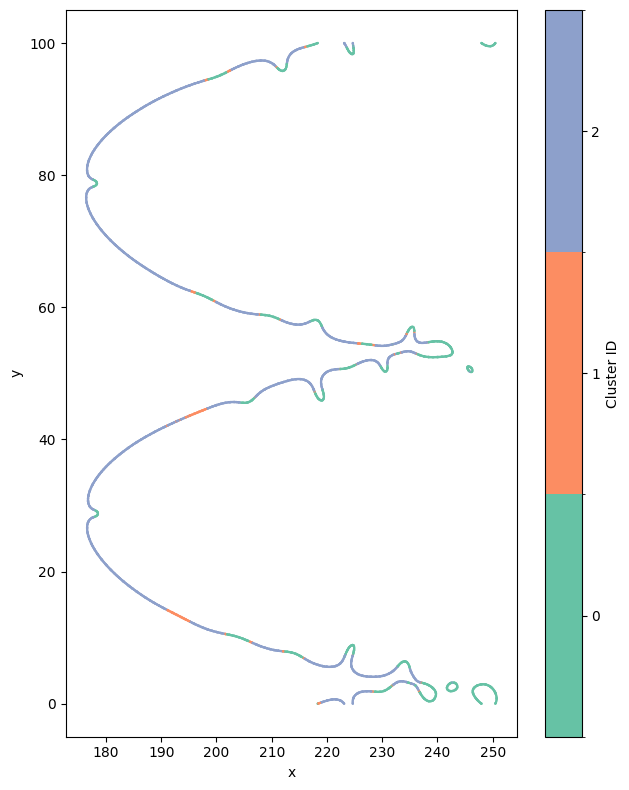

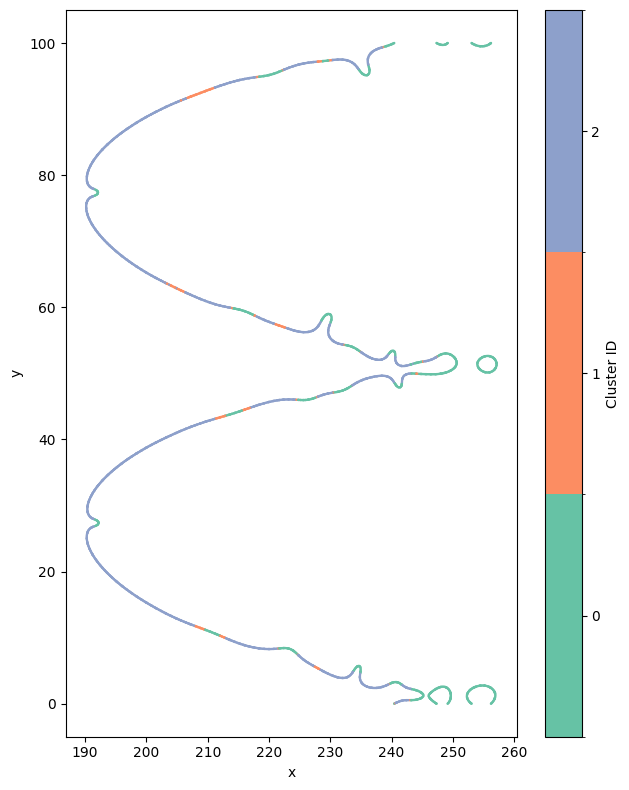

In [4]:
curv_col = CURVATURE_COLUMN
if curv_col not in dfc.columns:
    raise ValueError(f"CURVATURE_COLUMN '{curv_col}' not found in dataframe")

if len(CURVATURE_BOUNDS) != 2:
    raise ValueError("CURVATURE_BOUNDS must contain exactly two values")
low, high = CURVATURE_BOUNDS
if low >= high:
    raise ValueError("CURVATURE_BOUNDS must be strictly increasing (low < high)")

dfc["cluster"] = np.digitize(
    dfc[curv_col].to_numpy(),
    bins=[low, high],
    right=True,
)
dfc["cluster_conf"] = 1.0

print(f"\nCurvature bins: {CURVATURE_BOUNDS} -> clusters 0..{N_CLUSTERS - 1}")

summary_global = (
    dfc.groupby("cluster")
    .agg(
        n=(TARGET_VAR, "size"),
        sd_mean=(TARGET_VAR, "mean"),
        sd_std=(TARGET_VAR, "std"),
        conf_mean=("cluster_conf", "mean"),
        conf_max=("cluster_conf", "max"),
    )
    .reset_index()
    .sort_values("cluster")
)
print("\nCurvature-bin cluster summary (pooled):")
print(summary_global.to_string(index=False))

summary_by_t = (
    dfc.groupby(["timestep", "cluster"])
    .agg(n=(TARGET_VAR, "size"), sd_mean=(TARGET_VAR, "mean"), conf_mean=("cluster_conf", "mean"))
    .reset_index()
    .sort_values(["timestep", "cluster"])
)
print("\nCluster occupancy / Sd mean by timestep:")
print(summary_by_t.to_string(index=False))

for ts in TIME_STEPS:
    sub = dfc[dfc["timestep"] == ts]
    if len(sub) == 0:
        continue
    labeled_cluster_plot_xy(
        sub, N_CLUSTERS,
        title=f"CURVATURE bins | isotherm {ISOLEVEL} | timestep {ts}"
    )



### Per-cluster RF models + importance

In [ ]:
importances: Dict[int, pd.Series] = {}
metrics_rows: List[dict] = []
used_method: Dict[int, str] = {}
trained_models: Dict[int, RandomForestRegressor] = {}
cluster_test_data: Dict[int, dict] = {}

feature_names = list(model_features)

for cl in range(N_CLUSTERS):
    sub = dfc[dfc["cluster"] == cl].copy()
    n_cl = len(sub)
    print(f"\n--- Cluster {cl} (CURVATURE BIN) | n={n_cl} ---")

    if n_cl > 0:
        plot_curvature_distribution(
            sub,
            cluster_id=cl,
            curvature_col=CURVATURE_COLUMN,
            bins=HIST_BINS,
            n_clusters=N_CLUSTERS,
        )
        plot_target_distribution(
            sub,
            cluster_id=cl,
            target_var=TARGET_VAR,
            target_label=TARGET_LABEL,
            bins=HIST_BINS,
            n_clusters=N_CLUSTERS,
        )

    # cluster-level descriptive stats (useful overview)
    y_all = sub[TARGET_VAR].to_numpy()
    conf_all = sub["cluster_conf"].to_numpy()

    if n_cl < MIN_CLUSTER_SAMPLES:
        print(f"Skipping (n < MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
        metrics_rows.append({
            "cluster": cl,
            "n_total": int(n_cl),
            "n_train": 0,
            "n_test": 0,
            "r2": np.nan,
            "rmse": np.nan,
            "importance_method": "skipped",
            "target_mean": float(np.nanmean(y_all)) if n_cl > 0 else np.nan,
            "target_std": float(np.nanstd(y_all)) if n_cl > 0 else np.nan,
            "conf_mean": float(np.nanmean(conf_all)) if n_cl > 0 else np.nan,
            "conf_max": float(np.nanmax(conf_all)) if n_cl > 0 else np.nan,
        })
        continue

    X = sub[model_features].to_numpy()
    y = y_all

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    model = RandomForestRegressor(**MODEL_PARAMS)
    model.fit(Xtr, ytr)

    ypred = model.predict(Xte)
    plot_true_vs_pred(
        yte,
        ypred,
        cluster_id=cl,
        target_label=TARGET_LABEL,
    )
    r2 = float(r2_score(yte, ypred))
    rmse = float(np.sqrt(mean_squared_error(yte, ypred)))
    print(f"R^2={r2:.4f} | RMSE={rmse:.6e}")

    imp, method = compute_importance(
        model=model,
        X_train=Xtr,
        X_test=Xte,
        y_test=yte,
        feature_names=feature_names,
        prefer_shap=PREFER_SHAP,
        random_state=RANDOM_STATE,
        shap_sample_max=SHAP_SAMPLE_MAX,
        shap_background_max=200,
        shap_feature_perturbation="tree_path_dependent",
        allow_fallback_to_permutation=True,
    )

    used_method[cl] = method
    importances[cl] = imp
    trained_models[cl] = model
    cluster_test_data[cl] = dict(Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte)

    print(f"Importance method: {method}")
    print("Top features:")
    for i, (fname, val) in enumerate(imp.head(TOPN_PRINT).items(), 1):
        print(f"  {i:02d}. {fname}  ({val:.4e})")

    metrics_rows.append({
        "cluster": cl,
        "n_total": int(n_cl),
        "n_train": int(Xtr.shape[0]),
        "n_test": int(Xte.shape[0]),
        "r2": r2,
        "rmse": rmse,
        "importance_method": method,
        "target_mean": float(np.mean(y_all)),
        "target_std": float(np.std(y_all)),
        "conf_mean": float(np.mean(conf_all)),
        "conf_max": float(np.max(conf_all)),
    })
    # Importance bar plot (VERTICAL) + 45° labels + no title
    top = imp.head(TOPN_PRINT)  # keep descending order
    plt.figure(figsize=(9, 4))
    top.plot(kind="bar")
    plt.ylabel(f"Importance ({method})")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    save_then_show(
        f"importance_bar_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_cluster{cl}_{method}_top{TOPN_PRINT}"
    )



# Save overview/metrics files (NEW)
metrics_df = pd.DataFrame(metrics_rows).sort_values("cluster")
metrics_csv = SAVE_DIR / "cluster_overview.csv"
metrics_txt = SAVE_DIR / "cluster_overview.txt"
metrics_df.to_csv(metrics_csv, index=False)

with open(metrics_txt, "w", encoding="utf-8") as f:
    f.write("Cluster overview (CURVATURE BINS)\n")
    f.write(f"ISOLEVEL={ISOLEVEL}, TIME_STEPS={TIME_STEPS}, LAT_SIZE={LAT_SIZE}, PHI={PHI}\n")
    f.write(f"TARGET_VAR={TARGET_VAR}, TEST_SIZE={TEST_SIZE}, MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES}\n")
    f.write("\n")
    f.write(metrics_df.to_string(index=False))
    f.write("\n\n")
    f.write("Notes:\n")
    f.write("- r2/rmse computed on held-out test split.\n")
    f.write("- conf_mean/conf_max are 1.0 for deterministic curvature bins.\n")

print("\nPer-cluster model metrics (curvature bins):")
print(metrics_df.to_string(index=False))
print(f"\n[INFO] Wrote overview files:\n  {metrics_csv}\n  {metrics_txt}")


# Heatmap comparison across clusters
if importances:
    trained_clusters = sorted(importances.keys())

    imp_mat = pd.DataFrame(index=feature_names)
    for cl in trained_clusters:
        imp_mat[f"cluster_{cl}"] = importances[cl].reindex(feature_names).fillna(0.0)

    imp_norm = imp_mat.copy()
    for col in imp_norm.columns:
        s = imp_norm[col].sum()
        if s > 0:
            imp_norm[col] /= s

    imp_norm["avg"] = imp_norm.mean(axis=1)
    top_feats = imp_norm.sort_values("avg", ascending=False).head(TOPN_HEATMAP).index
    heat = imp_norm.loc[top_feats, [c for c in imp_norm.columns if c != "avg"]]

    plt.figure(figsize=(1.2 * len(trained_clusters) + 3, 0.35 * len(top_feats) + 2))
    plt.imshow(heat.to_numpy(), aspect="auto")
    plt.xticks(np.arange(len(heat.columns)), heat.columns, rotation=45, ha="right")
    plt.yticks(np.arange(len(heat.index)), heat.index)
    plt.colorbar(label="Normalized importance (per cluster)")
    plt.tight_layout()
    save_then_show(f"importance_heatmap_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_top{TOPN_HEATMAP}")

    print("\nTop features (normalized importance per cluster):")
    print(heat.round(4).to_string())


### SHAP plots


In [ ]:
def shap_importance_plots_for_cluster(
    cluster_id: int,
    trained_models: dict,
    cluster_test_data: dict,
    feature_names: list[str],
    max_points: int = 5000,
    random_state: int = 0,
):
    """
    Produces:
      1) SHAP beeswarm ("bumblebee") summary plot
      2) SHAP bar summary plot
      3) SHAP dependence plots for the top features
         CHANGED: remove coloring (no interaction coloring)
    """
    import shap  # type: ignore

    if cluster_id not in trained_models:
        raise ValueError(f"Cluster {cluster_id} not in trained_models. Was it skipped due to MIN_CLUSTER_SAMPLES?")

    model = trained_models[cluster_id]
    Xte = cluster_test_data[cluster_id]["Xte"]

    # Subsample for speed if needed
    if Xte.shape[0] > max_points:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(Xte.shape[0], size=max_points, replace=False)
        Xplot = Xte[idx]
    else:
        Xplot = Xte

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(Xplot)  # regression: (n, p)

    # 1) Beeswarm
    shap.summary_plot(
        shap_values,
        Xplot,
        feature_names=feature_names,
        plot_type="dot",
        show=False
    )
    plt.tight_layout()
    save_png(f"shap_beeswarm_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_cluster{cluster_id}_n{Xplot.shape[0]}")
    plt.show()

    # 2) Bar summary
    shap.summary_plot(
        shap_values,
        Xplot,
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.tight_layout()
    save_png(f"shap_bar_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_cluster{cluster_id}_n{Xplot.shape[0]}")
    plt.show()

    # 3) Dependence plots (top features) — remove coloring
    mean_abs = np.mean(np.abs(shap_values), axis=0)
    order = np.argsort(mean_abs)[::-1]
    topk = min(4, len(feature_names))

    for j in range(topk):
        feat_idx = int(order[j])
        feat_name = feature_names[feat_idx]

        # CHANGED: interaction_index=None removes the colored interaction overlay and colorbar
        shap.dependence_plot(
            feat_name,
            shap_values,
            Xplot,
            feature_names=feature_names,
            interaction_index=None,
            show=False
        )
        plt.tight_layout()
        save_png(f"shap_dependence_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_cluster{cluster_id}_{feat_name}_n{Xplot.shape[0]}")
        plt.show()


# Example usage: run SHAP for all trained clusters (recommended)
for cl in sorted(trained_models.keys()):
    shap_importance_plots_for_cluster(
        cluster_id=cl,
        trained_models=trained_models,
        cluster_test_data=cluster_test_data,
        feature_names=feature_names,
        max_points=min(SHAP_SAMPLE_MAX, 2000),
        random_state=0,
    )

print(f"\nSaved PNG plots + overview files to: {SAVE_DIR}")
